# Heavy class overlap

This notebook's goal is to evaluate class overlap, size it and study how to mitigate its impact  

In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import KMeans
from scipy.spatial.distance import squareform
from mpl_toolkits.mplot3d import Axes3D
import gower
import prince
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, recall_score, roc_auc_score, roc_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from collections import Counter
from typing import List
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

# import from custom package
from auxFuns.EDA import *
from auxFuns.modelling import *

In [4]:
import auxFuns.EDA 
importlib.reload(auxFuns.EDA)

import auxFuns.modelling
importlib.reload(auxFuns.modelling)

<module 'auxFuns.modelling' from 'c:\\Users\\angel\\Documents\\VSCode\\rsv_modelling_transfer_learning\\auxFuns\\modelling.py'>

In [5]:
# Load of the data and filter in the needed features

raw_datasets_path = os.getcwd() + '/datasets/raw'
processed_datasets_path = os.getcwd() + '/datasets/processed'

rsv_predictors_df_v2 = pd.read_csv(processed_datasets_path + '/rsv_predictors_phase1_daysDedup_seasons_prevTest_v2.csv',low_memory=False)
rsv_predictors_df_v2 = make_it_categorical_v2(rsv_predictors_df_v2)

In [6]:
selected_features = ['sex', 'marital_status', 'race','patient_regional_location', 'age_group',
                     'Acute_upper_respiratory_infection','Influenza','Pneumonia','Bronchitis','Symptoms_and_signs__digestive_system_and_abdomen','General_symptoms_and_signs','any_symptom',
                     'COPD','AIDS','Asthma_chronic','CCI',
                     'sine','cosine','calendar_year', 
                     'healthcare_seeking', 'influenza_vaccine',
                     'n_symptoms','prev_positive_rsv','previous_test_daydiff','n_immunodeficiencies', 
                     'tumor_indicator','tumor_last_year',
                     'season',
                     'n_tests_that_day']
selected_features_v1 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'season','multiple_tests']
selected_features_v2 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'key_comorbidities','Pneumonia',
                     'season','month_of_the_test','multiple_tests',
                     'BPA','BPAI']
selected_features_v3 = selected_features_v2 + ['race', 'age_group','marital_status','sex',
                                                    'patient_regional_location','calendar_year']

selected_features_v1.append('RSV_test_result')
selected_features_v2.append('RSV_test_result')
selected_features_v3.append('RSV_test_result')

In [7]:
df1 = rsv_predictors_df_v2[selected_features_v2]
df1 = df1.drop(['month_of_the_test'], axis = 1)
df1.shape, df1.columns


((86058, 20),
 Index(['n_tests_that_day', 'sine', 'cosine', 'previous_test_daydiff',
        'Bronchitis', 'CCI', 'Acute_upper_respiratory_infection',
        'n_immunodeficiencies', 'n_symptoms', 'healthcare_seeking',
        'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
        'key_comorbidities', 'Pneumonia', 'season', 'multiple_tests', 'BPA',
        'BPAI', 'RSV_test_result'],
       dtype='object'))

# 1. Visualization of heavy class overlap

In [12]:
random_seed = 42
n_components = 5

X = df1.drop(['RSV_test_result'], axis = 1)

famd = prince.FAMD(n_components=n_components, random_state=random_seed)
famd = famd.fit(X)

X_transformed = famd.transform(X)

df_transformed = X_transformed.copy()
# Ensure both df1 and df_transformed present the same records in the same order
df1 = df1.sort_index()
df_transformed = df_transformed.sort_index()

assert all(df1.index == df_transformed.index), "The indices of df1 and df_transformed do not match."

df_transformed['RSV_test_result'] = [1 if label == 'Positive' else 0 for label in df1['RSV_test_result']]

In [22]:
# SMOTE resampling to allow class overlap visualization
df_modelling = df_transformed[[0,1,2,3,4,'RSV_test_result']]

X = df_modelling.drop(['RSV_test_result'], axis=1)
y = df_modelling['RSV_test_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Defining the pipeline
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.1)
steps = [('o', over), ('u', under)]
pipeline = imbPipeline(steps=steps)

# Over sampled and undersampled data generation
X_train, y_train = pipeline.fit_resample(X_train, y_train)

data_smote = pd.concat([X_train, y_train], axis = 1)

y_train.value_counts()


RSV_test_result
0    66720
1     6672
Name: count, dtype: int64

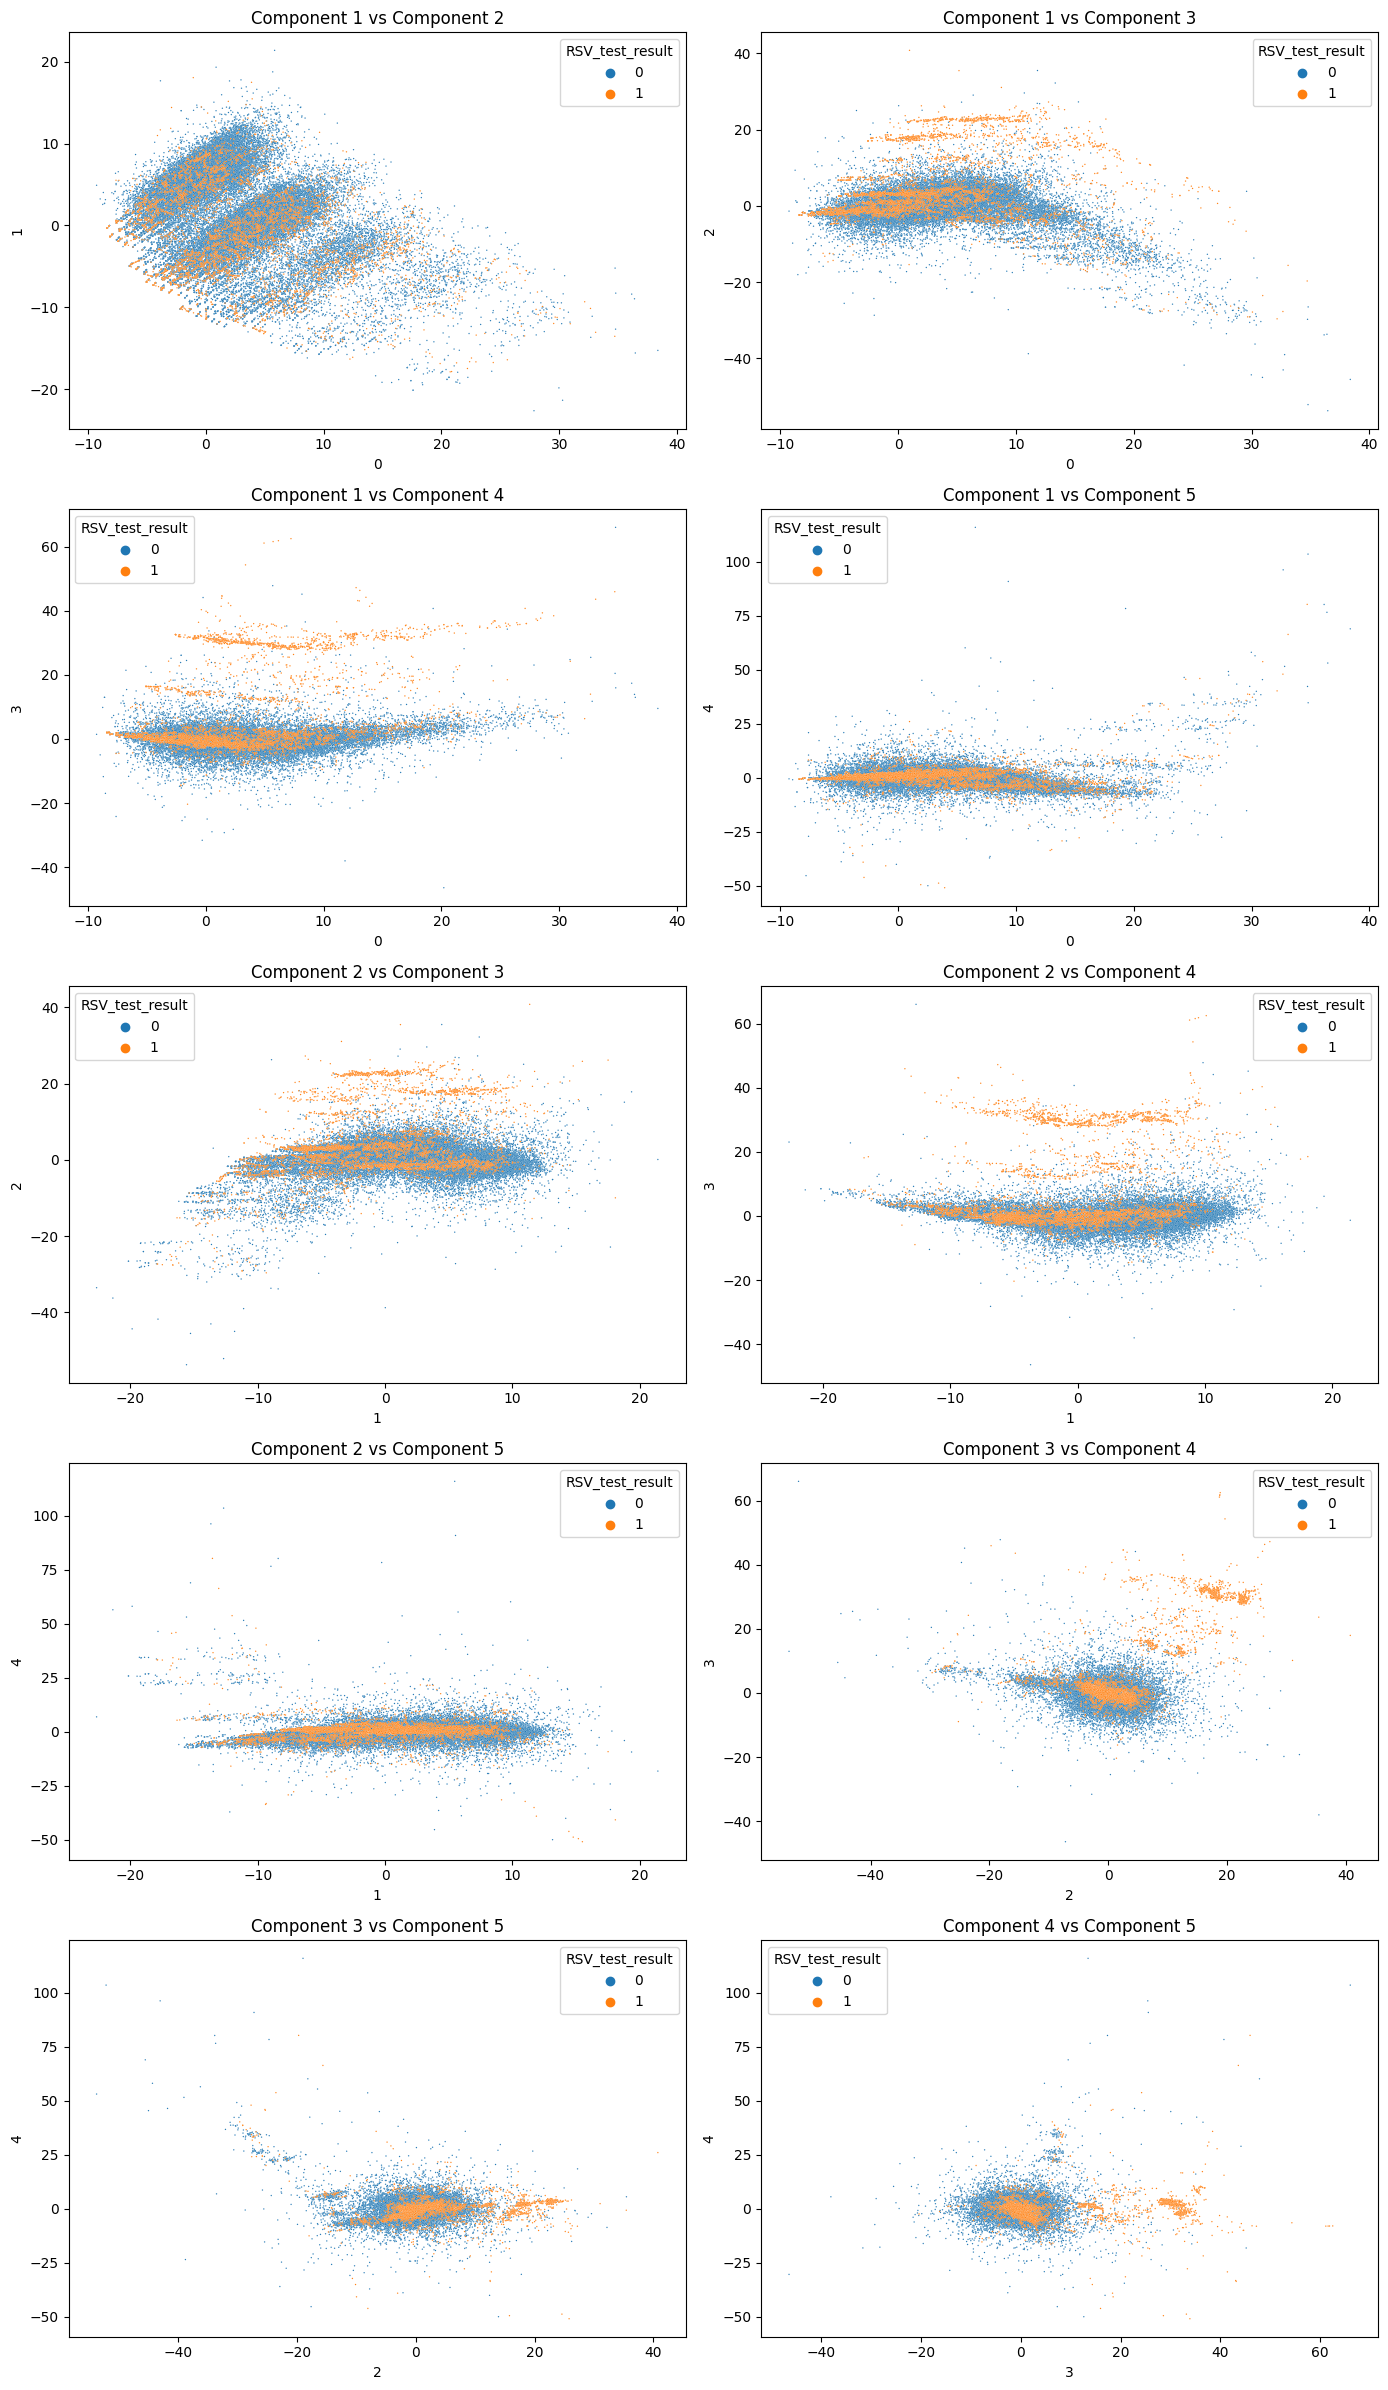

In [23]:
# Visualization of the SMOTE data
# 
# For clarity, let us plot the 10 different planes
f, axes = plt.subplots(5, 2, figsize=(14, 24))

# Two-dimensional plots
sns.scatterplot(data=data_smote, x=0, y=1, hue='RSV_test_result', ax=axes[0, 0], s = 1)
axes[0, 0].set_title('Component 1 vs Component 2')

sns.scatterplot(data=data_smote, x=0, y=2, hue='RSV_test_result', ax=axes[0, 1], s = 1)
axes[0, 1].set_title('Component 1 vs Component 3')

sns.scatterplot(data=data_smote, x=0, y=3, hue='RSV_test_result', ax=axes[1, 0], s = 1)
axes[1, 0].set_title('Component 1 vs Component 4')

sns.scatterplot(data=data_smote, x=0, y=4, hue='RSV_test_result', ax=axes[1, 1], s = 1)
axes[1, 1].set_title('Component 1 vs Component 5')

sns.scatterplot(data=data_smote, x=1, y=2, hue='RSV_test_result', ax=axes[2, 0], s = 1)
axes[2, 0].set_title('Component 2 vs Component 3')

sns.scatterplot(data=data_smote, x=1, y=3, hue='RSV_test_result', ax=axes[2, 1], s = 1)
axes[2, 1].set_title('Component 2 vs Component 4')

sns.scatterplot(data=data_smote, x=1, y=4, hue='RSV_test_result', ax=axes[3, 0], s = 1)
axes[3, 0].set_title('Component 2 vs Component 5')

sns.scatterplot(data=data_smote, x=2, y=3, hue='RSV_test_result', ax=axes[3, 1], s = 1)
axes[3, 1].set_title('Component 3 vs Component 4')

sns.scatterplot(data=data_smote, x=2, y=4, hue='RSV_test_result', ax=axes[4, 0], s = 1)
axes[4, 0].set_title('Component 3 vs Component 5')

sns.scatterplot(data=data_smote, x=3, y=4, hue='RSV_test_result', ax=axes[4, 1], s = 1)
axes[4, 1].set_title('Component 4 vs Component 5')

plt.tight_layout()